In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig


In [3]:
# 使用本地模型路径
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "./deepseek-7b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True,
    output_attentions=True
)
model.generation_config = GenerationConfig.from_pretrained(model_path)
model.generation_config.pad_token_id = model.generation_config.eos_token_id

text = "what is python?"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs['input_ids']




Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


输出对象包含的属性: ['logits', 'past_key_values', 'hidden_states', 'attentions']
output每个key的值: {'logits': tensor([ 9.2500, 12.8125, 14.0625, 10.3750,  9.9375], device='cuda:0')}

Logits形状: torch.Size([1, 5, 102400])
output attention shape: torch.Size([1, 32, 5, 5])
output hidden states shape: torch.Size([1, 5, 4096])
Layer 3 hidden states shape: (5, 4096)
Layer 15 hidden states shape: (5, 4096)
Layer 21 hidden states shape: (5, 4096)
Layer 30 hidden states shape: (5, 4096)


/home/lhy/downloads/miniconda/envs/multimodal/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


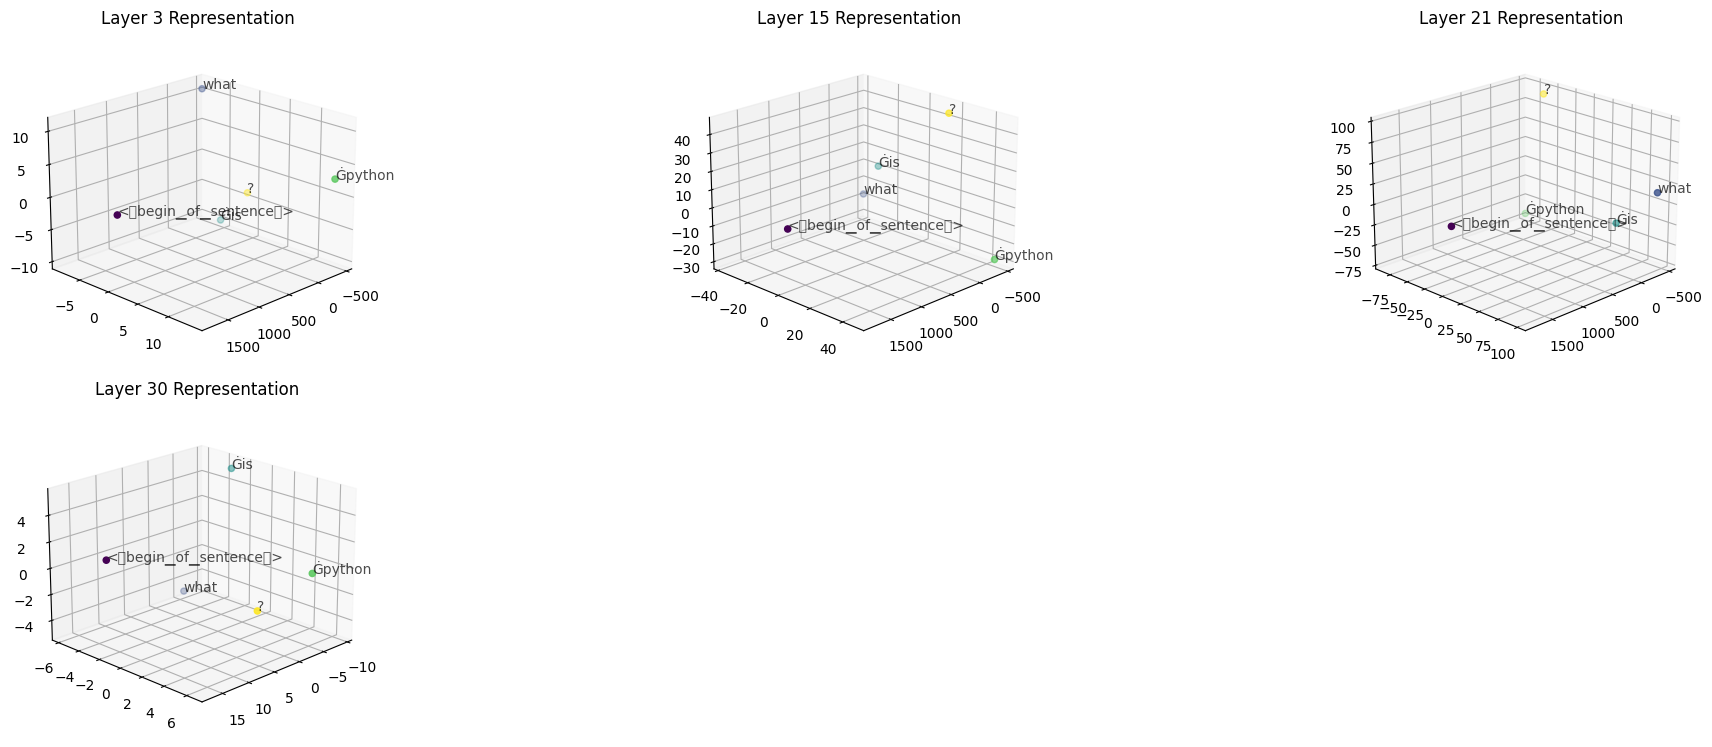

In [15]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)
    
    
print("输出对象包含的属性:", [k for k in outputs.keys()])
print("output每个key的值:", {k: v[0, 0, :5] for k, v in outputs.items() if isinstance(v, torch.Tensor)})


    
    
hidden_states = [h.to(torch.float32).cpu() for h in outputs.hidden_states]  # 分层转换
attentions = [a.to(torch.float32).cpu() for a in outputs.attentions]       # 分层转换
logits = outputs.logits.to(torch.float32).cpu()
    # 添加注意力权重可视化

# hidden_states = outputs.hidden_state
# attentions = outputs.attentions
# logits = outputs.logits


# 1. 输出张量（logits）分析
# logits = outputs.logits
print("\nLogits形状:", logits.shape)  # [batch_size, seq_len, vocab_size]
print("output attention shape:", outputs.attentions[0].shape)
print("output hidden states shape:", outputs.hidden_states[0].shape)

# 获取最后一个token的预测概率（典型的下一个token预测）
last_token_logits = logits[0, -1, :]
probs = torch.softmax(last_token_logits, dim=-1)
selected_layers = [3, 15, 21, 30]
token_labels = tokenizer.convert_ids_to_tokens(input_ids[0])



plt.figure(figsize=(20, 15))
for i, layer_idx in enumerate(selected_layers):
    # 提取对应层的隐藏状态 [batch_size, seq_len, hidden_dim]
    layer_hidden = hidden_states[layer_idx][0].cpu().numpy()
    print(f"Layer {layer_idx} hidden states shape:", layer_hidden.shape)
    
    # 使用PCA降维到3D
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(layer_hidden)
    
    # 创建3D子图
    ax = plt.subplot(4, 3, i+1, projection='3d')
    scatter = ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], 
                        c=range(len(reduced)), cmap='viridis')
    ax.set_title(f"Layer {layer_idx} Representation")
    
    # 标注token文本
    for j, (x, y, z) in enumerate(reduced):
        ax.text(x, y, z, token_labels[j], alpha=0.7)
    
    # 添加视角调整以获得更好的可视化效果
    ax.view_init(elev=20, azim=45)
    
plt.tight_layout()
plt.show()



关键信息汇总:
输入文本: what is python?
Tokenized输入: ['<｜begin▁of▁sentence｜>', 'what', 'Ġis', 'Ġpython', '?']
最后一个token的top5预测:
- 
: 0.7900
-  python: 0.0306
-  Python: 0.0128
-  what: 0.0113
-  : 0.0077


/tmp/ipykernel_3295222/444425521.py:17: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3295222/444425521.py:18: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from current font.
  plt.savefig('token_probabilities.png', bbox_inches='tight')


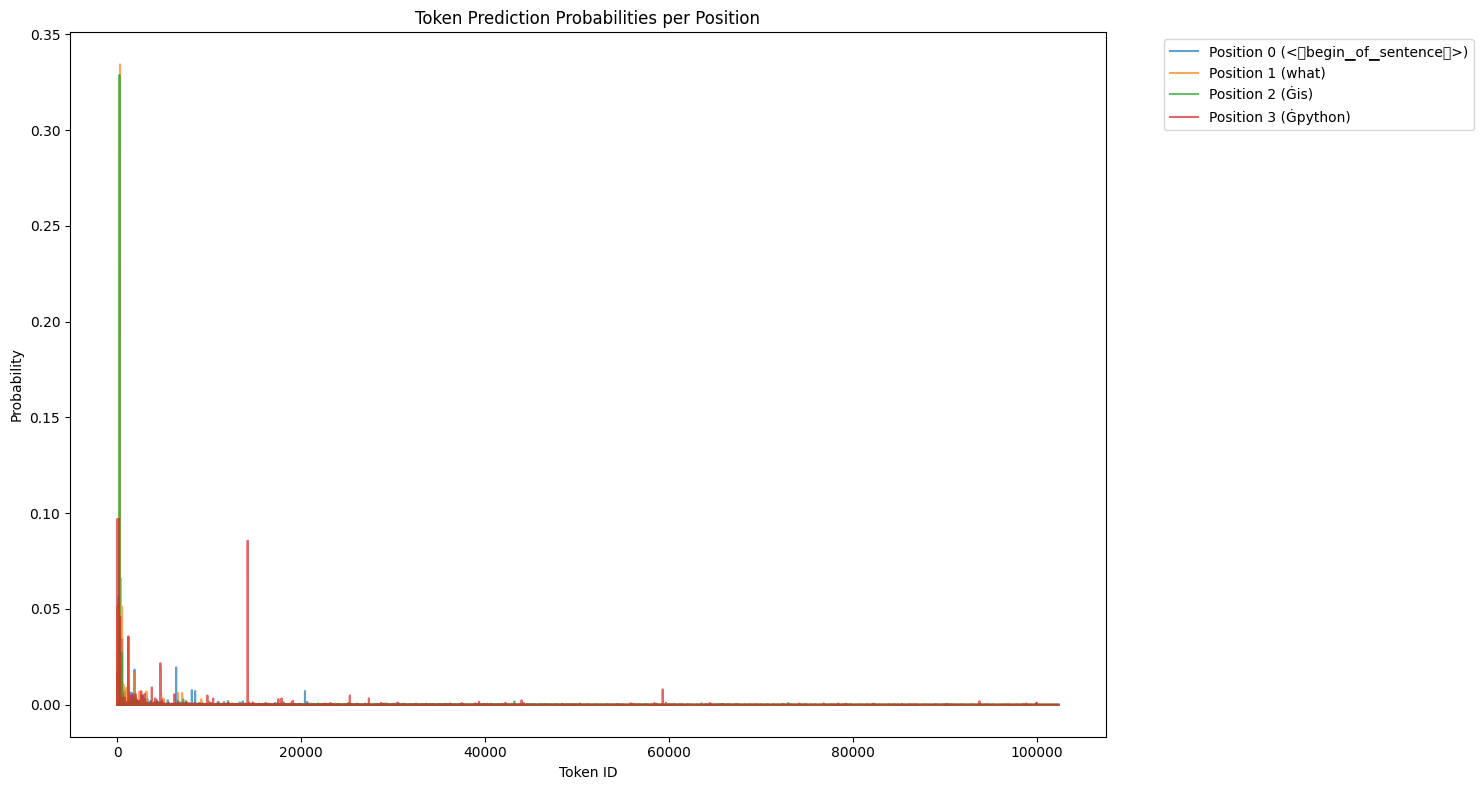

In [16]:
all_probs = torch.softmax(logits[0], dim=-1).cpu().numpy()

plt.figure(figsize=(15, 8))
for i, token in enumerate(token_labels):
    # 获取每个位置预测下个token的概率分布
    if i < all_probs.shape[0]-1:  # 最后一个位置没有对应的预测
        plt.plot(all_probs[i], alpha=0.7, label=f"Position {i} ({token})")
        # plt.savefig(f"token_probabilities_{i}.png")
        



plt.xlabel("Token ID")
plt.ylabel("Probability")
plt.title("Token Prediction Probabilities per Position")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('token_probabilities.png', bbox_inches='tight')

# 打印关键信息
print("\n关键信息汇总:")
print(f"输入文本: {text}")
print(f"Tokenized输入: {token_labels}")
print(f"最后一个token的top5预测:")
top5_probs, top5_ids = torch.topk(probs, 5)
for p, id in zip(top5_probs, top5_ids):
    print(f"- {tokenizer.decode(id)}: {p.item():.4f}")